In [68]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

import pandas as pd
import seaborn as sns

from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils



In [69]:
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Same labels will be reused throughout the program
LABELS = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S']
# The number of steps within one time segment
TIME_PERIODS = 18
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 3

In [70]:
def read_data(file_path):

    column_names = ['student-id',
                    'activity-label',
                    'timestamp',
                    'x',
                    'y',
                    'z']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z'] = df['z'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('raw/train/phone/accel/data_1601_accel_phone.txt')
x_test=read_data('raw/test/phone/accel/data_1620_accel_phone.txt')


In [71]:
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 81457



,student-id,activity-label,timestamp,x,y,z
0,1601,A,265073308304101,4.7,9.1,0.1
1,1601,A,265073348330612,5.4,15.6,-0.6
2,1601,A,265073388368581,6.4,12.9,0.5
3,1601,A,265073428111445,10.5,13.2,-1.0
4,1601,A,265073468081082,16.1,2.7,1.1
5,1601,A,265073508462957,0.4,6.5,-3.8
6,1601,A,265073547617695,-0.2,11.3,2.1
7,1601,A,265073587555769,9.9,5.6,0.1
8,1601,A,265073627620664,4.8,2.5,0.4
9,1601,A,265073667650612,2.9,3.8,1.1


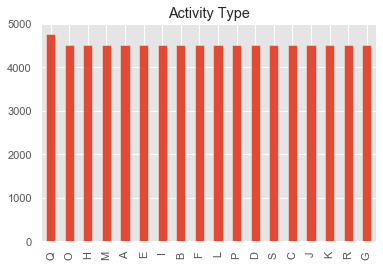

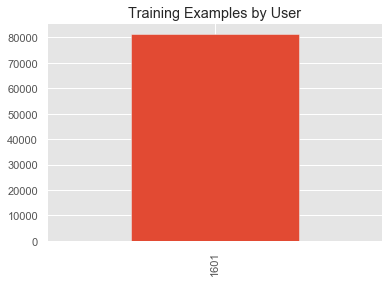

In [72]:
df['activity-label'].value_counts().plot(kind='bar',
                                   title='Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['student-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

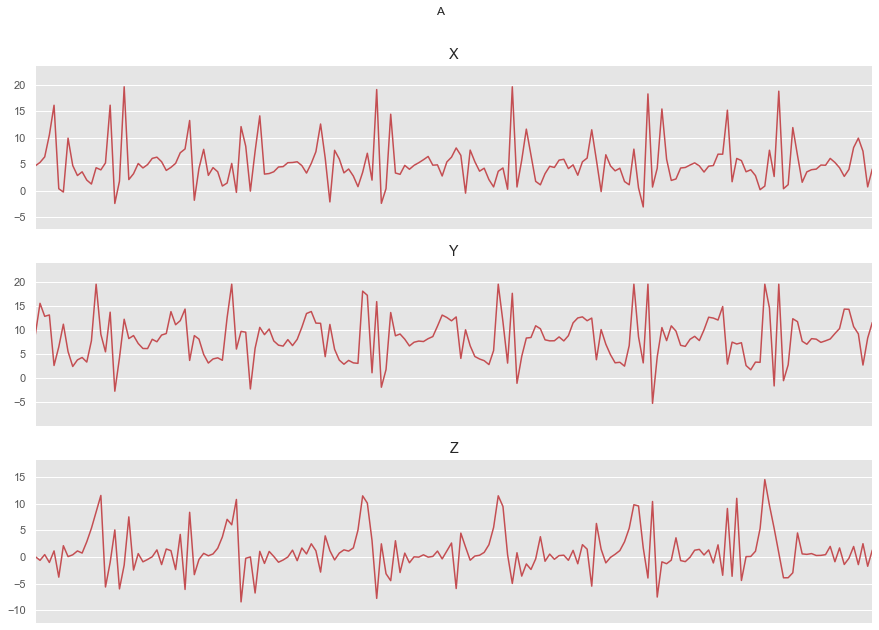

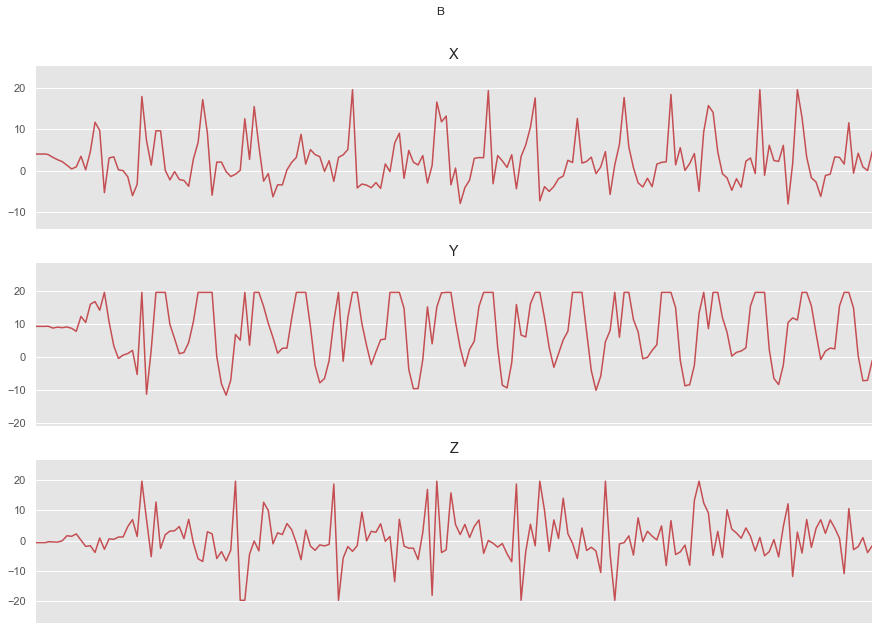

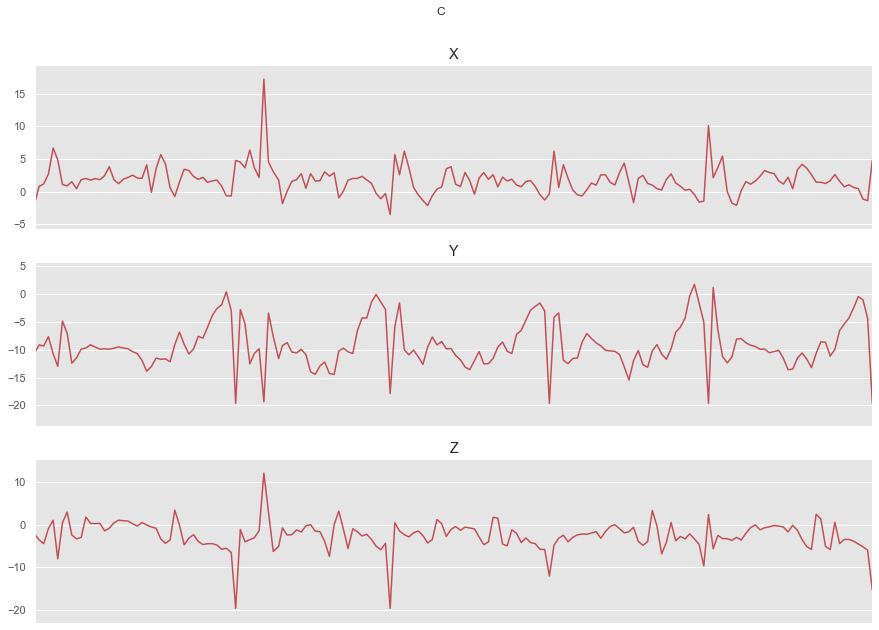

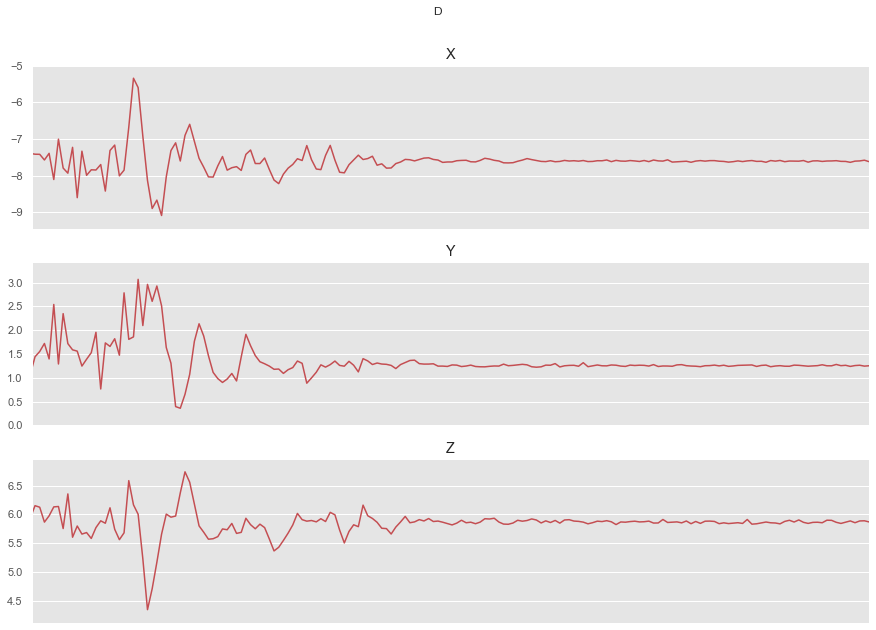

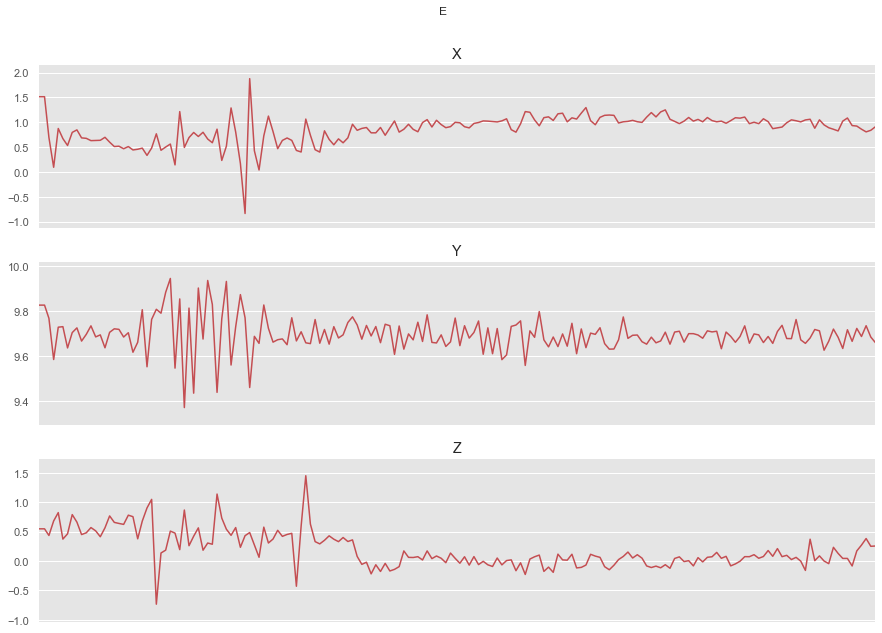

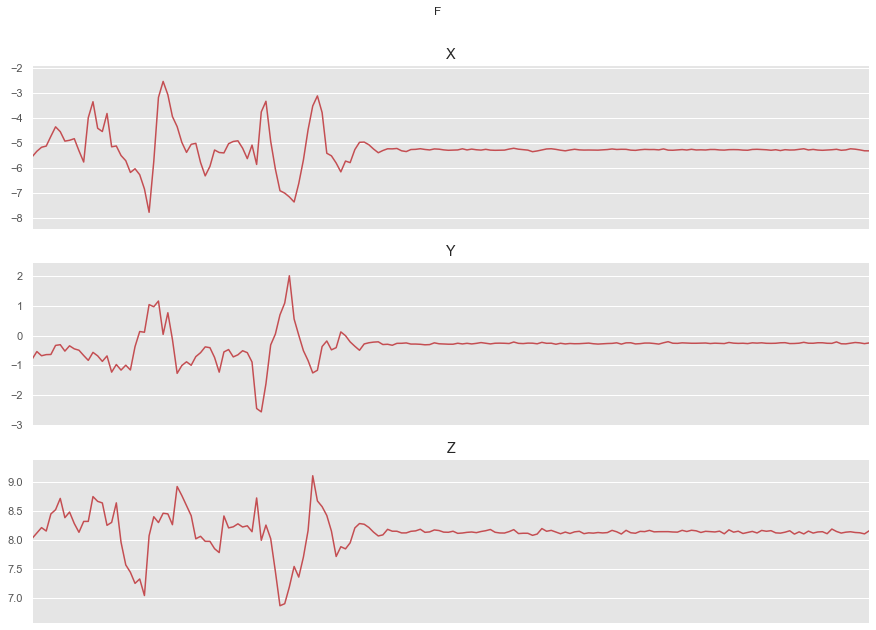

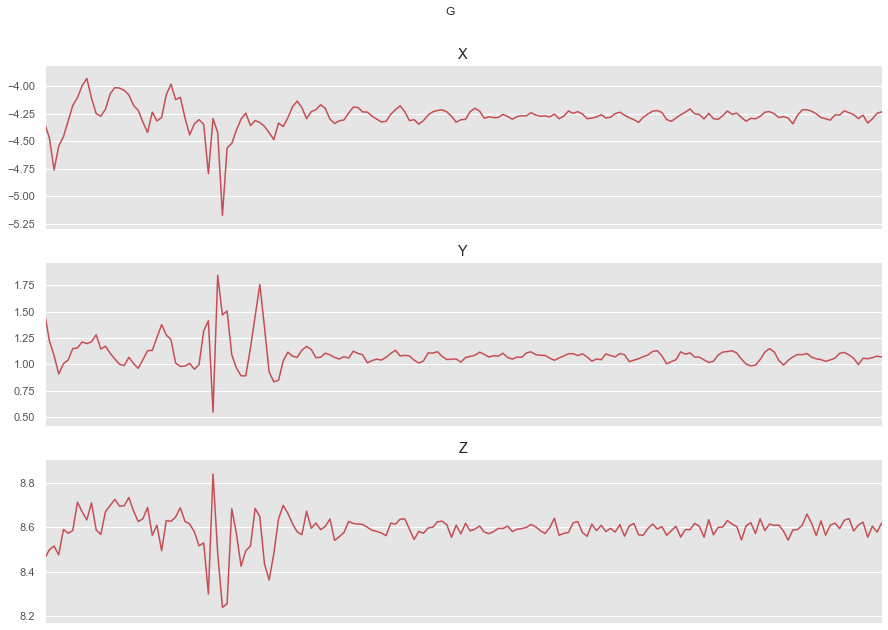

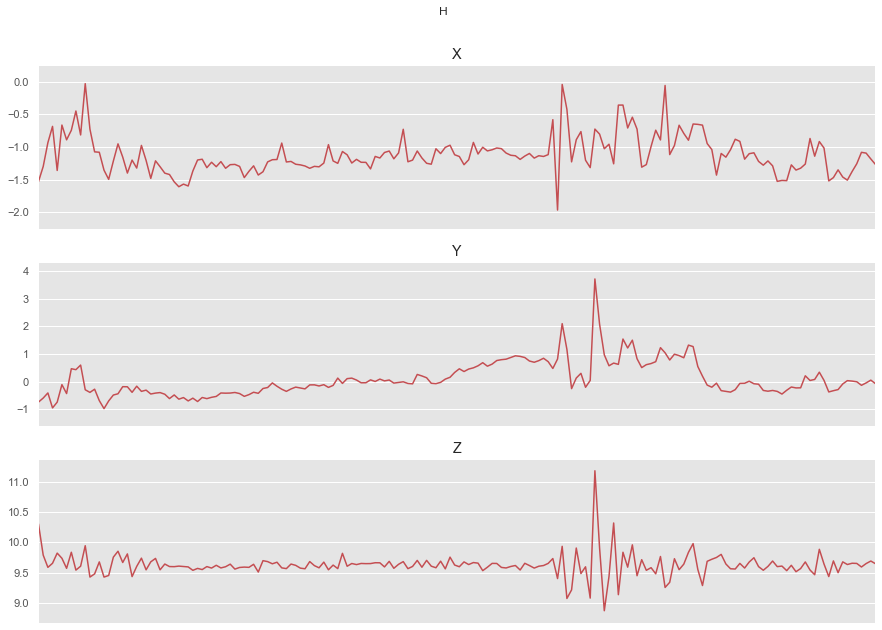

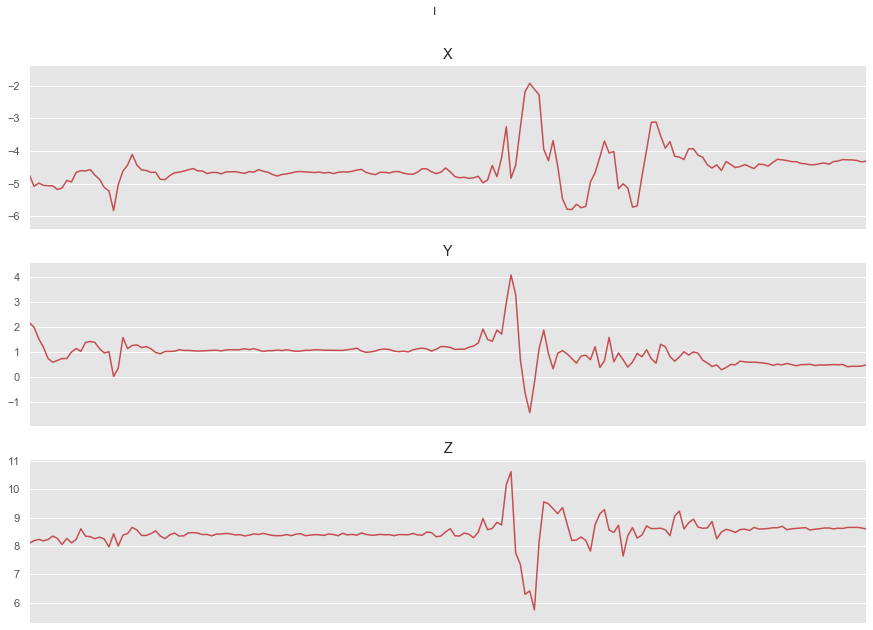

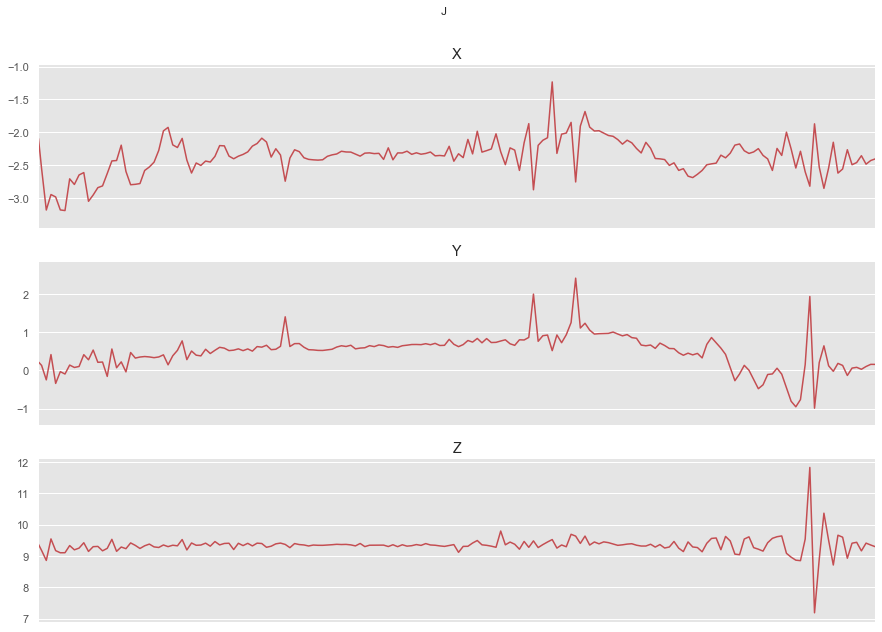

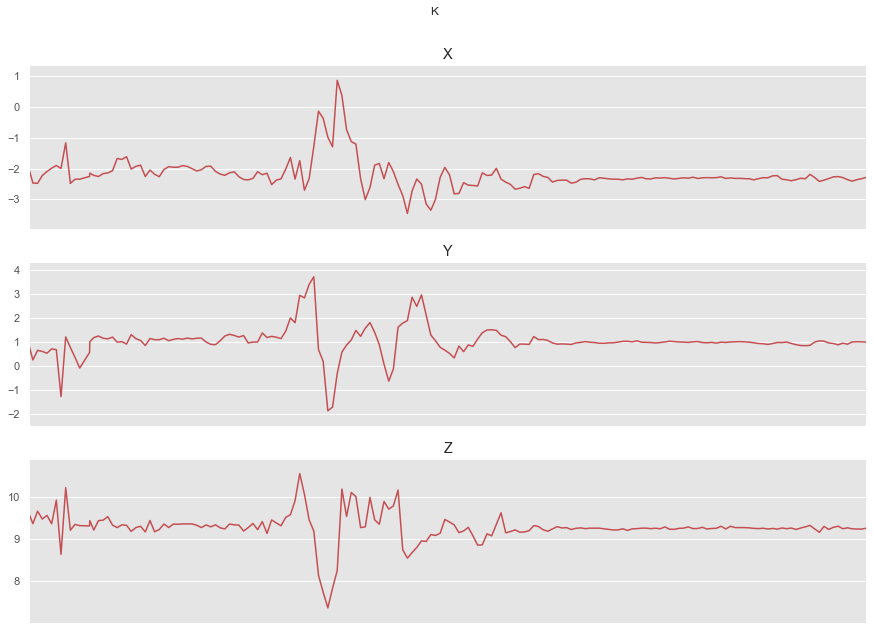

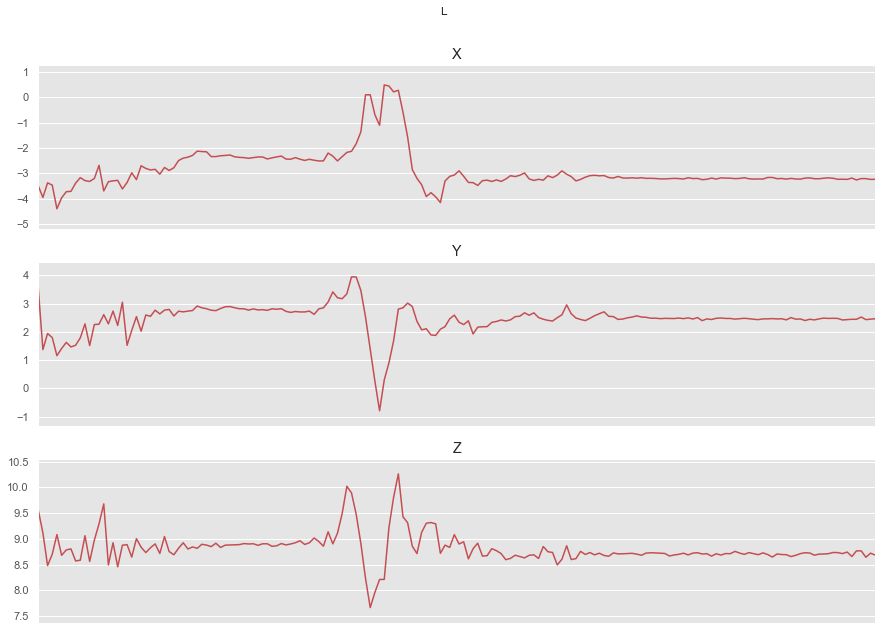

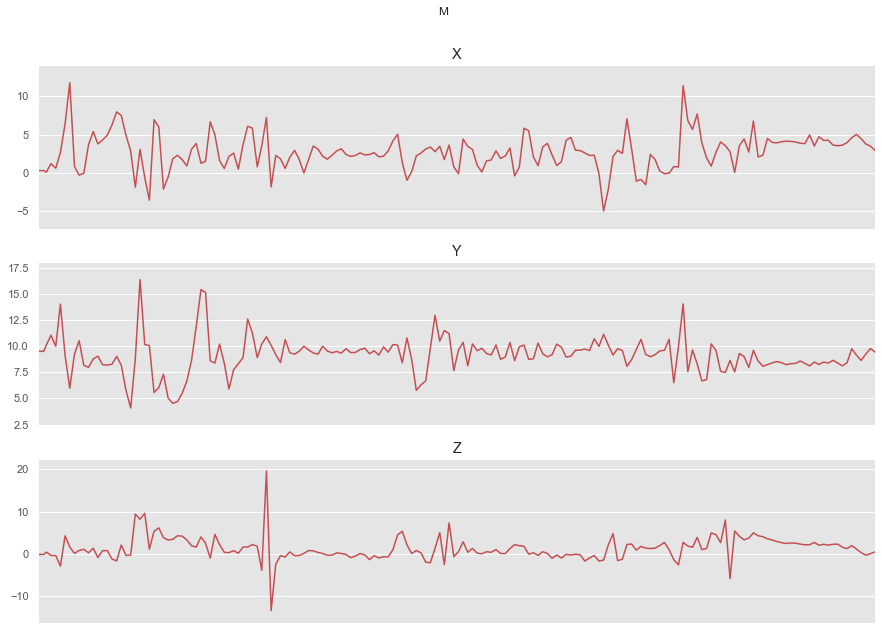

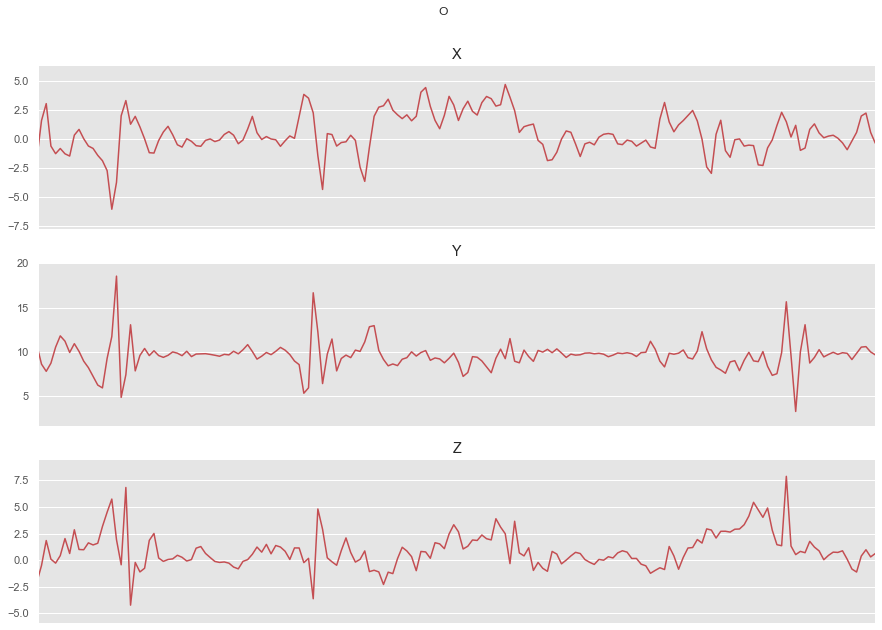

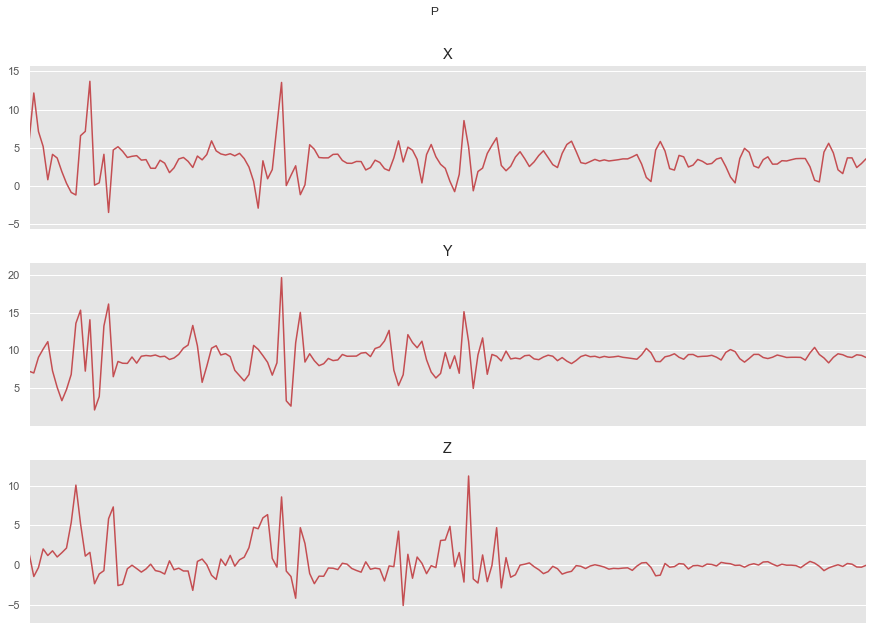

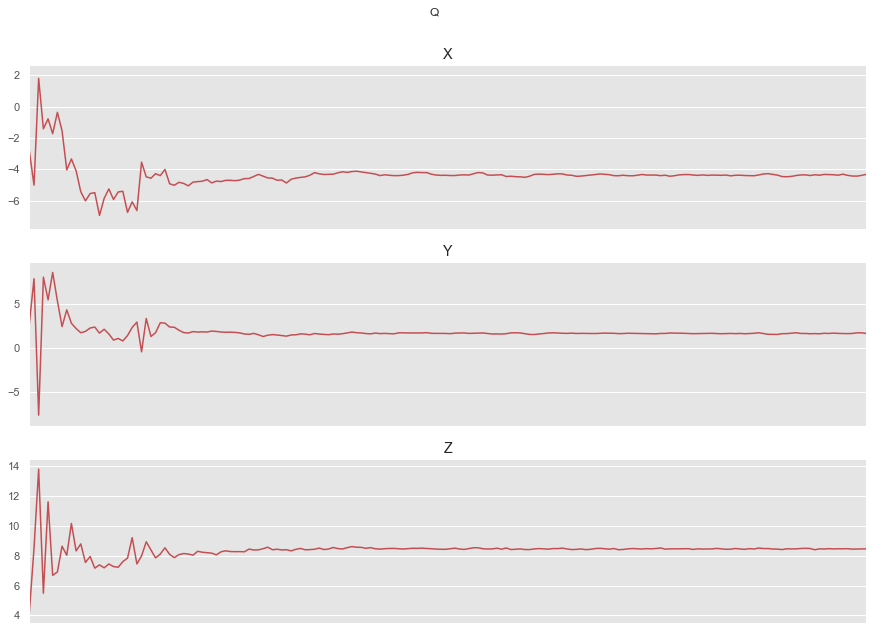

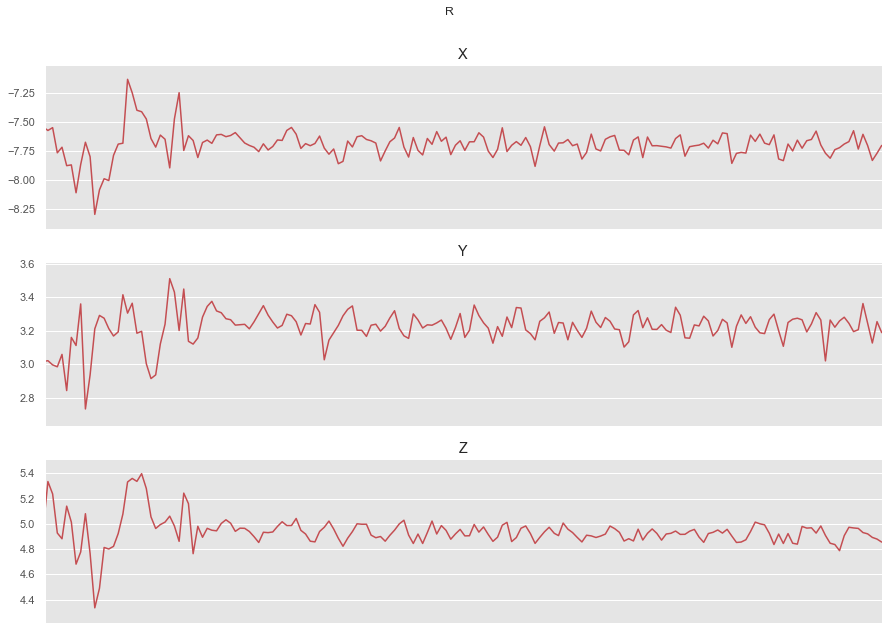

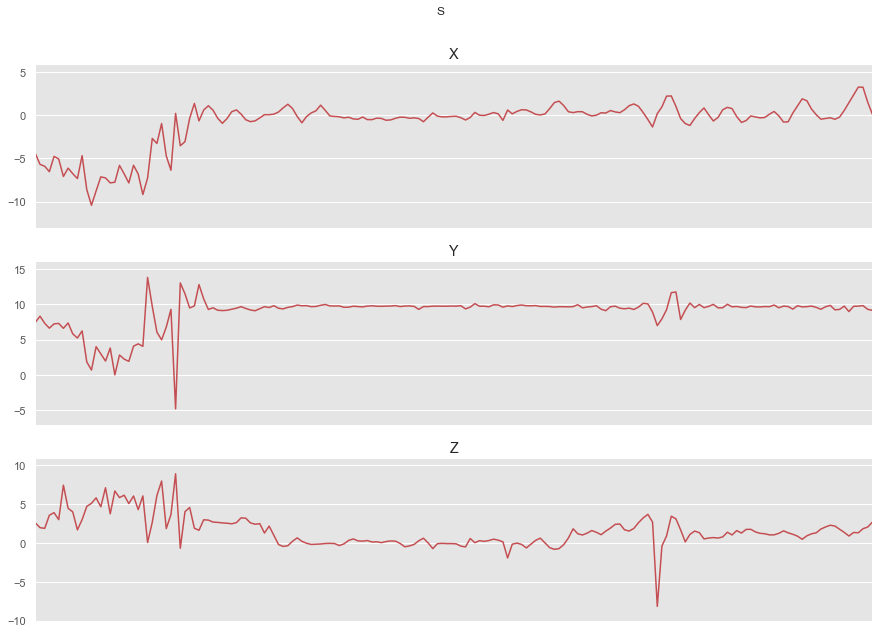

In [73]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x'], 'X')
    plot_axis(ax1, data['timestamp'], data['y'], 'Y')
    plot_axis(ax2, data['timestamp'], data['z'], 'Z')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity-label']):
    subset = df[df['activity-label'] == activity][:180]
    plot_activity(activity, subset)

In [74]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity-label'].values.ravel())

In [75]:
df_test = df[df['student-id'] > 1620]
df_train = df[df['student-id'] <= 1620]

In [76]:
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x'] = df_train['x'] / df_train['x'].max()
df_train['y'] = df_train['y'] / df_train['y'].max()
df_train['z'] = df_train['z'] / df_train['z'].max()
# Round numbers
df_train = df_train.round({'x': 6, 'y': 6, 'z': 6})

In [77]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i: i + time_steps]
        ys = df['y'].values[i: i + time_steps]
        zs = df['z'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)


In [78]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (27147, 18, 3)
27147 training samples
y_train shape:  (27147,)


In [79]:
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'O', 'P', 'Q', 'R', 'S']


In [80]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (27147, 54)
input_shape: 54


In [81]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [82]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (27147, 18)


In [83]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 18, 3)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 18, 100)           400       
_________________________________________________________________
dense_12 (Dense)             (None, 18, 100)           10100     
_________________________________________________________________
dense_13 (Dense)             (None, 18, 100)           10100     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 18)                32418     
Total params: 53,018
Trainable params: 53,018
Non-trainable params: 0
__________________________________________________

In [84]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 21717 samples, validate on 5430 samples
Epoch 1/50
21717/21717 [==============================] - 5s 216us/step - loss: 1.5807 - accuracy: 0.5363 - val_loss: 27.6029 - val_accuracy: 0.0856
Epoch 2/50
21717/21717 [==============================] - 4s 183us/step - loss: 0.3919 - accuracy: 0.8696 - val_loss: 48.4179 - val_accuracy: 0.0634
Epoch 3/50
21717/21717 [==============================] - 4s 172us/step - loss: 0.2779 - accuracy: 0.8997 - val_loss: 53.5607 - val_accuracy: 0.0179
Epoch 4/50
21717/21717 [==============================] - 4s 173us/step - loss: 0.2534 - accuracy: 0.9106 - val_loss: 54.4586 - val_accuracy: 0.0867
Epoch 5/50
21717/21717 [==============================] - 4s 177us/step - loss: 0.2351 - accuracy: 0.9171 - val_loss: 54.1827 - val_accuracy: 0.0350
Epoch 6/50
21717/21717 [==============================] - 4s 174us/step - loss: 0.2252 - accuracy: 0.9211 - val_loss: 52.0924 - val_accuracy: 0.0750
Epoch 7/50
21717/21717 [==============================] -

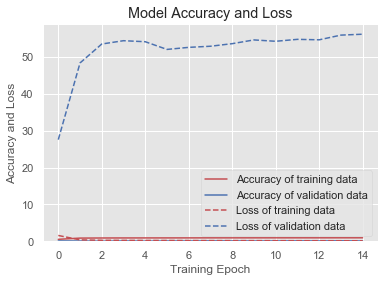

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90      1502
         1.0       0.99      1.00      0.99      1504
         2.0       1.00      1.00      1.00      1503
         3.0       0.50      1.00      0.66      1504
         4.0       0.90      0.99      0.94      1504
         5.0       1.00      1.00      1.00      1503
         6.0       0.54      0.98      0.70      1503
         7.0       0.98      0.99      0.99      1504
         8.0       0.80      0.97      0.88      1504
         9.0       0.96      0.97      0.96      1504
        10.0       0.98      0.99      0.98      1503
        11.0       0.99      1.00      0.99      1504
        12.0       0.58      0.74      0.65      1504
        13.0       0.48      0.87      0.62      1506
        14.0       0.88      0.57      0.69      1504
        15.0       0.00      0.00      0.00      1587
        16.0       0.00      0.00      0.00      1503
        17.0       0.00    

C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:

plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, max_y_pred_train))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
confusion_matrix(y_train,max_y_pred_train)

Precision: 100.0%
Recall: 100.0%
f1_score: 100.0%

Confusion Matrix:
[[1502    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0 1504    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0 1503    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0 1504    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0 1504    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0 1503    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0 1503    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0 1504    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    0 1504    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    0    0 1504    0    0    0    0
    

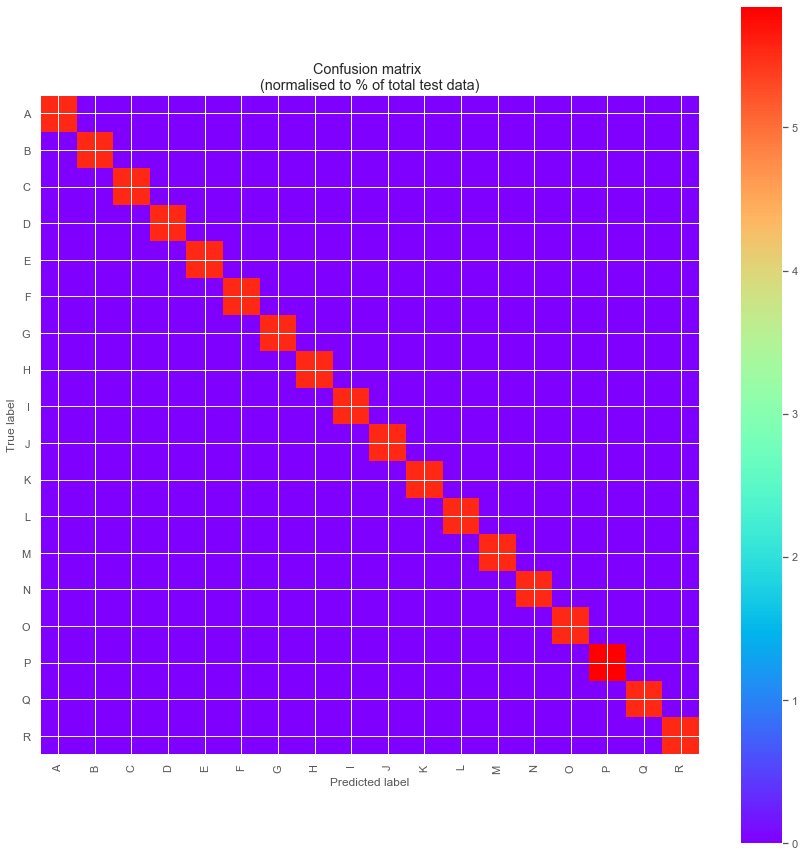

In [97]:
predictions = y_train_hot.argmax(1)

print("Precision: {}%".format(100*metrics.precision_score(y_train, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_train, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_train, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_train, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()